<a href="https://colab.research.google.com/github/EmYassir/rl_optimal_control/blob/main/projectile_single_shooting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

In [ ]:
import jax
import jax.numpy as jnp
from jax.config import config; config.update("jax_enable_x64", True)
from scipy.integrate import solve_ivp

In [ ]:
plt.rcParams['figure.dpi'] = 200

In [ ]:
def projectile(kappa=0.02, g=0.032):
  def f(t, x):
    height, velocity, angle = x
    height_prime = jnp.tan(angle)
    velocity_prime = (-g/velocity)*jnp.tan(angle) - kappa*velocity*(1./jnp.cos(angle))
    angle_prime = (-g/(velocity**2))
    return jnp.array([height_prime, velocity_prime, angle_prime])
  return f

In [ ]:
def plot_projectile(times, states, x0, t_span):
  fig, ax = plt.subplots()

  ax.set_xlabel("Horizontal Distance")
  ax.set_ylabel("Height")
  ax.set_title(f"Motion of a Projectile $\\theta={jnp.rad2deg(x0[-1]):.2f}$, $\\epsilon={states[0,-1]:.2f}$")

  ax.plot(times, states[0,:], zorder=10)
  ax.axhline(0, c='r', linestyle='dotted')
  ax.axvline(t_span[-1], c='r', linestyle='dotted')

  ax.add_artist(plt.Circle((t_span[-1], 0), 0.5, color='r'))
  ax.add_artist(plt.Circle((t_span[-1], 0), 0.4, color='w'))
  ax.add_artist(plt.Circle((t_span[-1], 0), 0.3, color='r'))
  ax.add_artist(plt.Circle((t_span[-1], 0), 0.2, color='w'))
  ax.add_artist(plt.Circle((t_span[-1], 0), 0.1, color='r'))
  ax.add_artist(
      Wedge((0,0), 0.5, 0., jnp.rad2deg(x0[-1]), width=0.01,
            fill=False, alpha=0.5, edgecolor='k', linestyle='-', zorder=4))

  ax.set_ylim([-0.6, 3])
  ax.set_xlim(t_span[0], t_span[1]+1)
  ax.set_aspect('equal', 'box')
  ax.grid(True, alpha=0.2)
  ax.set_axisbelow(True)

In this simplified model, our goal is to set the angle on a cannon so as to hit ($y=0$) the target $x = 5$ m away. This problem can be viewed as a two-point boundary value problem. Here's what happens when choosing the wrong angle for this problem:

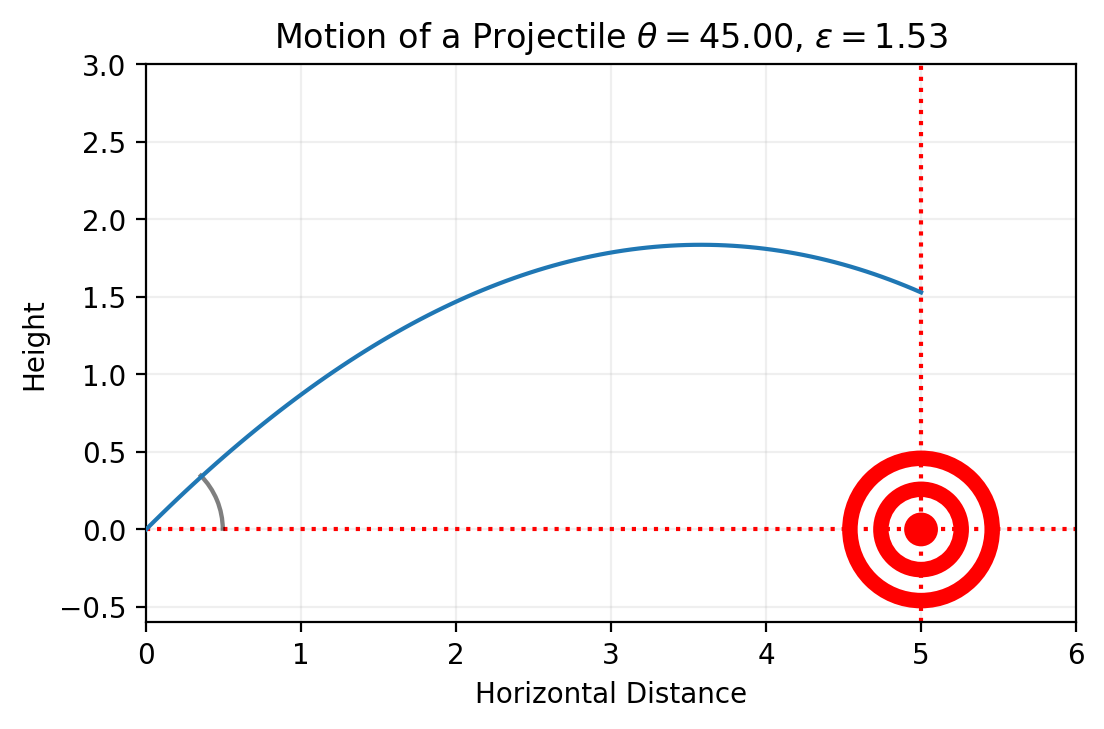

In [ ]:
t_span = [0, 5]
npoints = 100
t_eval = jnp.linspace(*t_span, npoints)

x0 = jnp.array([0, 0.5, jnp.deg2rad(45)])
solution = solve_ivp(projectile(), t_span, x0, t_eval=t_eval)
plot_projectile(solution.t, solution.y, x0, t_span)

# Solution by Direct Single Shooting

The goal of this question is to find the correct angle by direct single shooting. Use Newton's method to minimize the vertical distance to the target and approximate the corresponding jacobian by directly differentiating the time marching procedure (discrete adjoint).

In [ ]:
def rk4_step(f, t, x, h):
  k1 = h*f(t, x)
  k2 = h*f(t + h/2, x + k1/2)
  k3 = h*f(t + h/2, x + k2/2)
  k4 = h*f(t + h, x + k3)
  return (1/6)*(k1 + 2*k2 + 2*k3 + k4)

def integrate(method, f, x0, start, stop, num):
  h = (stop - start)/(num - 1)
  def step(carry, t):
    curr_t, curr_state = carry
    curr_state = curr_state + method(f, curr_t, curr_state, h)
    curr_t = curr_t + h
    return (curr_t, curr_state), (curr_t, curr_state)

  _, (times, states) = jax.lax.scan(step, (start, x0), None, length=num-1) 
  times = jnp.concatenate((jnp.atleast_1d(start), times))
  states = jnp.vstack((x0, states))
  return times, states

In [ ]:
num_nodes = 100
xstart = 0.
xtarget = 5.
t_span = [xstart, xtarget]
target_height = 0.

initial_height = 0.
initial_velocity = 0.5
initial_angle = jnp.deg2rad(5)

@jax.jit
def error(angle):
  # IMPLEMENT: evaluate the boundary condition. You need to call the integrate function above to simulate the system
  initial_conditions = jnp.array([initial_height, initial_velocity, angle])
  times, states = integrate(rk4_step, projectile(), initial_conditions, xstart, xtarget, num_nodes)
  return  target_height - states[-1][0]

In [ ]:
from jax import jacobian

def newton(fun, x0, nsteps, jac_fun=None):
  def newton_step(x):
    if jac_fun is None:
      b, A = fun(x), jacobian(fun)(x)
    else:
      b, A = jac_fun(x)

    b, A = jnp.atleast_1d(b), jnp.atleast_2d(A)
    return jnp.squeeze(b), jnp.squeeze(jnp.linalg.solve(A, b))

  x = x0
  for i in range(nsteps):
    val, step = newton_step(x)
    yield i, val, x
    x = x - step
  yield i+1, fun(x), x

In [ ]:
for i, val, angle in newton(error, initial_angle, 10):
  print(i, val, jnp.rad2deg(angle))

0 1.289354893498898 5.0
1 0.08079605779512578 20.56841900929086
2 0.00026831659916946973 21.668083720613474
3 2.9734890672162924e-09 21.67175997177894
4 1.7691896956663097e-16 21.67176001252012
5 -3.2615083846664307e-16 21.671760012520124
6 1.7691896956663097e-16 21.67176001252012
7 -3.2615083846664307e-16 21.671760012520124
8 1.7691896956663097e-16 21.67176001252012
9 -3.2615083846664307e-16 21.671760012520124
10 1.7691896956663097e-16 21.67176001252012


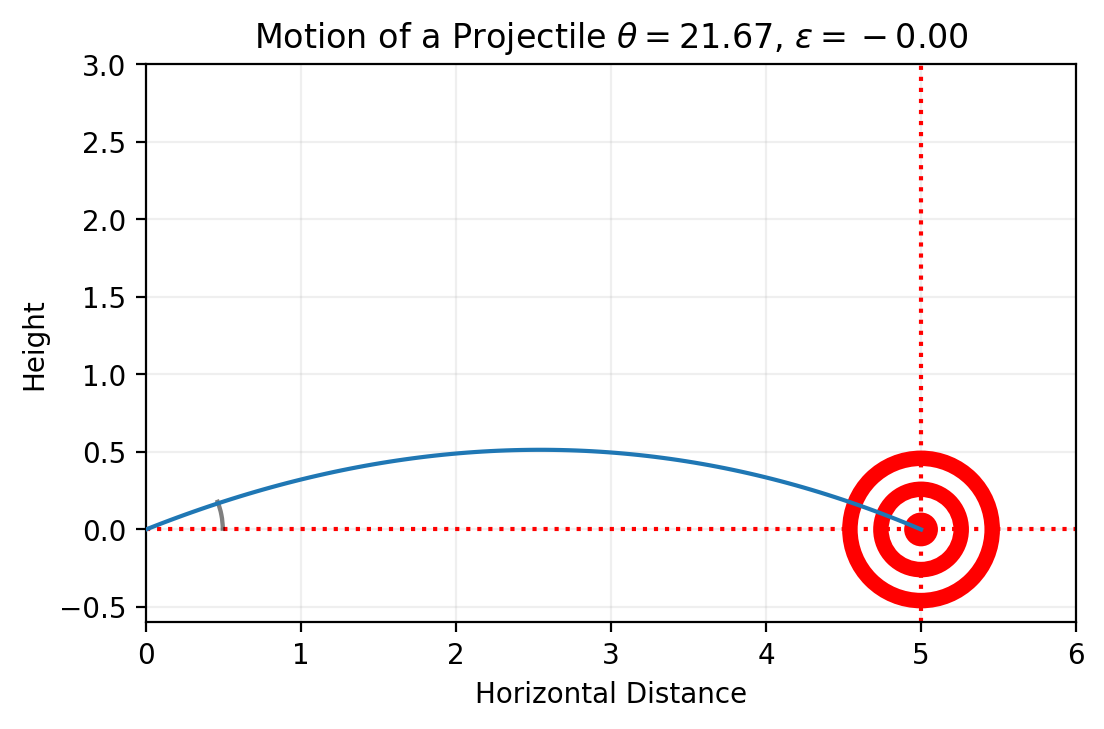

In [ ]:
initial_conditions = jnp.array([initial_height, initial_velocity, angle])
times, states = integrate(rk4_step, projectile(), initial_conditions, xstart, xtarget, num_nodes)
plot_projectile(times, states.T, initial_conditions, t_span)

# Solution by Indirect Single Shooting

Instead of approximating the jacobian in Newton's method using the discrete adjoint, use the forward sensitivity equation.

In [ ]:
from jax.flatten_util import ravel_pytree

def sensivity_equation(fun, ic_fun, t0, p):
  dx_fun = jacobian(fun, argnums=1)
  dp_fun = jacobian(fun, argnums=2)
  dp_ic = jacobian(ic_fun, argnums=1)

  # IMPLEMENT: The initial augmented state z0
  z0 =  (ic_fun(t0,p), jnp.ravel(dp_ic(t0,p)))
  z0_flat, unflatten = ravel_pytree(z0)

  def ic_augmented(t, p):
    return z0_flat

  def fun_augmented(t, z, p):
    x, s = unflatten(z)
    # zprime = IMPLEMENT: compute the time derivative of the augmented state (xdot, sdot). This is the variable that I call zprime
    sprime = dx_fun(t,x, p) @ s + dp_fun(t, x,  p)
    zprime = jnp.concatenate((fun(t, x,  p), jnp.ravel(sprime)))

    flat, _ = ravel_pytree(zprime)
    return flat

  return fun_augmented, ic_augmented

In [ ]:
fun = projectile()

def parametrized_ic_projectile(t, p):
  return jnp.array([initial_height, initial_velocity, p]) 

def parameterized_fun_projectile(t, x, p):
  return fun(t, x)

In [ ]:
def fwd_jac_fun(angle):
  fwd_fun, fwd_ic = sensivity_equation(parameterized_fun_projectile, parametrized_ic_projectile, xstart, angle)  
  solution = solve_ivp(lambda t,x: fwd_fun(t, x, angle), t_span, fwd_ic(xstart, angle))
  val = solution.y[0, -1]
  dp_xtf = solution.y[3:,-1]
  return val, dp_xtf[0]

for i, val, angle in newton(error, initial_angle, 10, jac_fun=fwd_jac_fun):
  print(i, val, jnp.rad2deg(angle))

0 -1.2889965032166424 5.0
1 -0.08087559639920108 20.564419804913424
2 -0.00029162089030815297 21.664995208654165
3 -9.057423944192067e-08 21.66898997174219
4 -2.7046337391922748e-11 21.668991212501304
5 -8.298917109073045e-15 21.668991212871806
6 -7.494005416219807e-16 21.66899121287192
7 -2.7755575615628914e-16 21.66899121287193
8 -1.942890293094024e-16 21.668991212871934
9 1.942890293094024e-16 21.668991212871937
10 0.00020208212293685554 21.668991212871934


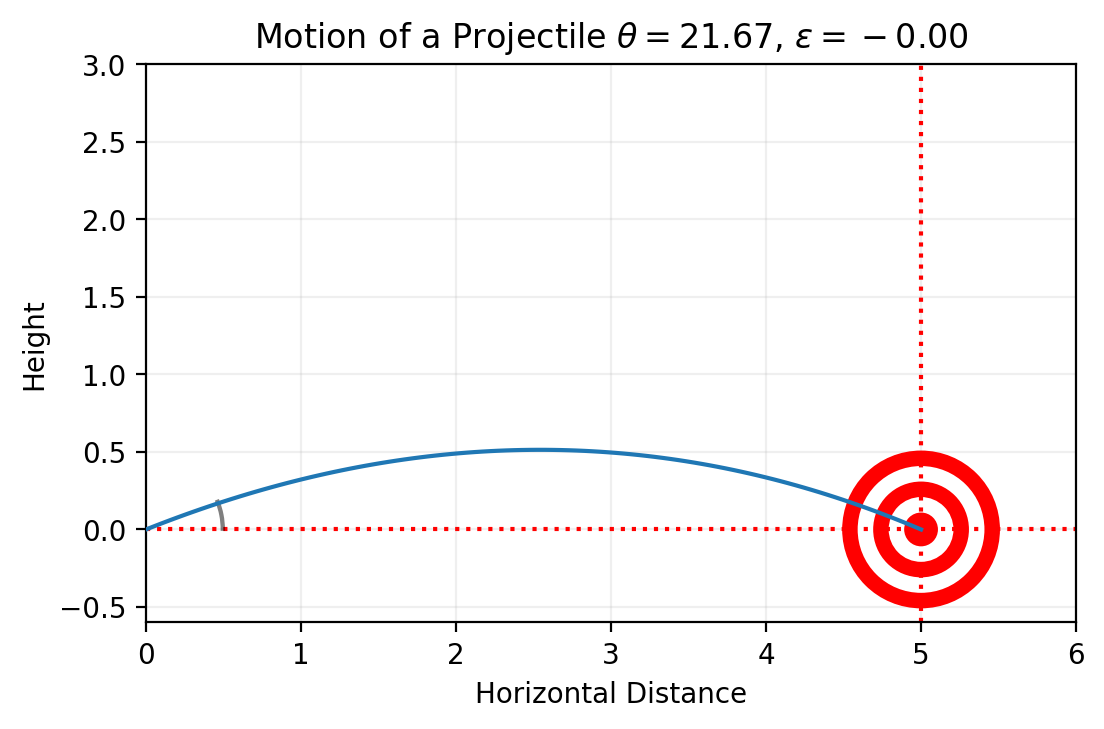

In [ ]:
t_eval = jnp.linspace(*t_span, 100)
x0 = parametrized_ic_projectile(xstart, angle)

solution = solve_ivp(fun, t_span, x0, t_eval=t_eval)
plot_projectile(solution.t, solution.y, x0, t_span)

# Indirect Single Shooting using Adjoint Sensitivity Equation

Instead of using the discrete adjoint equation as in the first exercise, implement the adjoint sensitivity equation to solve the BVP.

In [ ]:
from jax import vjp
from jax import grad

def adjoint_sensitivity_equation(terminal_cost, fun, ic_fun, t_span, p):
  t0, tf = t_span
  x0 = ic_fun(t0, p)
  p = jnp.atleast_1d(p)

  solution = solve_ivp(lambda t,x: fun(t, x, p), t_span, x0, dense_output=True)
  xfun = solution.sol

  # adjoint_tf = IMPLEMENT: value of the adjoint at the terminal time
  # qtf = IMPLEMENT: Initial value of the quadrature accumulation
  _, adjoint_tf = value_and_grad(lambda x, p: terminal_cost(x, p), argnums=0)(xfun(tf), p)
  qtf = 0.
  ztf = (adjoint_tf, qtf)
  adjoint_tf_flat, unflatten = ravel_pytree(ztf)

  def ic_augmented(t, p):
    return adjoint_tf_flat

  def fun_augmented(t, z):
    adjoint, _ = unflatten(z)
    x = xfun(t)
    
    # IMPLEMENT: use JAX's vjp() function to compute the thing you need here
    v_fun_adj, fun_adj = vjp(lambda x: fun(t, x, p), x)
    v_fun_q, fun_q = vjp(lambda p: fun(t, x, p), p)
    ztf = (-1.0 * jnp.asarray(fun_adj(adjoint)), -1.0 * jnp.asarray(fun_q(adjoint)))
    flat, _ = ravel_pytree(ztf)
    return flat

  return fun_augmented, ic_augmented, xfun, unflatten

In [ ]:
from jax import value_and_grad

def terminal_cost(xf, p):
  return xf[0]

def parametrized_ic_projectile(t, p):
  return jnp.array([initial_height, initial_velocity, p]) 

def parameterized_fun_projectile(t, x, p):
  return fun(t, x)

def rev_jac_fun(angle):
  rev_fun, rev_ic, xfun, unflatten = adjoint_sensitivity_equation(terminal_cost, parameterized_fun_projectile, parametrized_ic_projectile, t_span, angle)  
  solution = solve_ivp(rev_fun, t_span[::-1], rev_ic(xstart, angle))

  adjoint0, q0 = unflatten(solution.y[:,-1])
  val, dp_varphi = value_and_grad(lambda x, p: terminal_cost(x, p), argnums=1)(xfun(t_span[-1]), angle)
  _, vjp_ic = vjp(lambda p: parametrized_ic_projectile(t_span[0], p), angle)
  
  # IMPLEMENT: Gradient evaluation, using vjp_ic provided above
  gradient = dp_varphi + vjp_ic(adjoint0) + q0
  return val, gradient

for i, val, angle in newton(error, initial_angle, 10, jac_fun=rev_jac_fun):
  print(i, val, jnp.rad2deg(angle))

0 -1.289054139775343 5.0
1 -0.08098518477420974 20.56470786073751
2 -0.0002550037731277044 21.66693793470796
3 4.640197259764278e-08 21.67043181419064
4 -8.914646798530157e-12 21.67043117841057
5 -1.4432899320127035e-15 21.670431178532716
6 -3.1086244689504383e-15 21.670431178532738
7 4.9960036108132044e-15 21.670431178532777
8 3.885780586188048e-15 21.67043117853271
9 -3.219646771412954e-15 21.670431178532656
10 9.698514218596982e-05 21.6704311785327


We can visualize the projectile's trajectory 

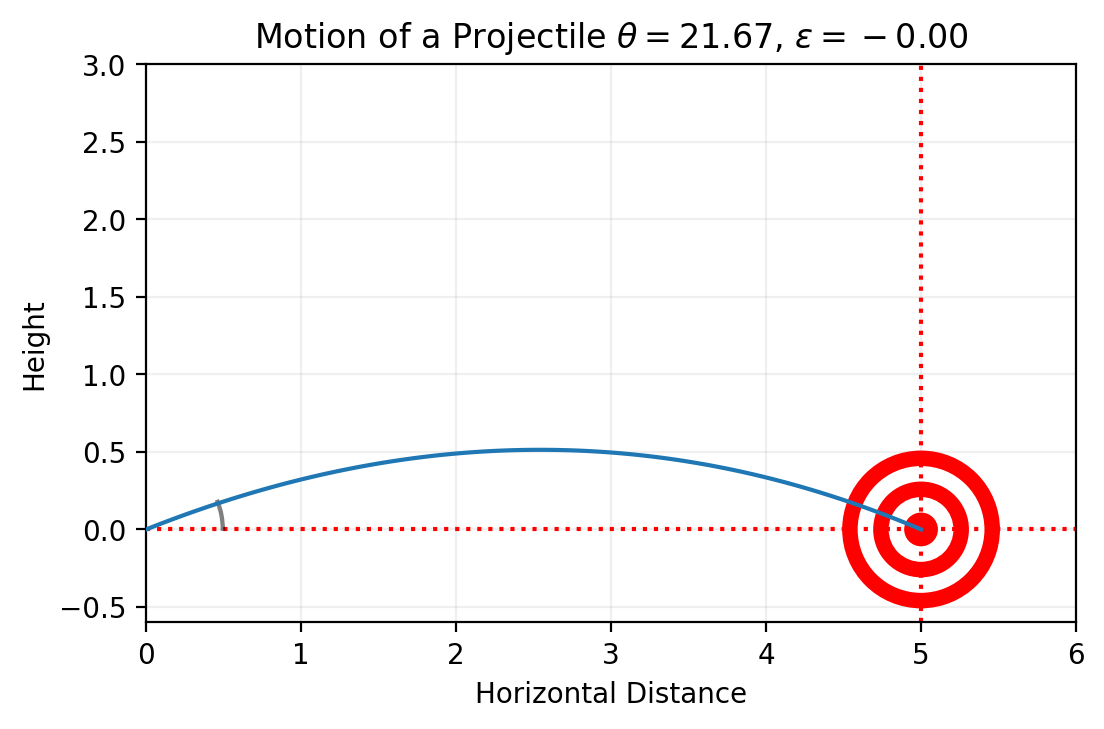

In [ ]:
t_eval = jnp.linspace(*t_span, 100)
x0 = parametrized_ic_projectile(xstart, angle)

solution = solve_ivp(fun, t_span, x0, t_eval=t_eval)
plot_projectile(solution.t, solution.y, x0, t_span)